In [1]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from ast import literal_eval
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [3]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "distilled_mech_reactions.parquet"
)
mm["mech_atoms"] = mm["mech_atoms"].apply(rc_to_nest)
mm["reaction_center"] = mm["reaction_center"].apply(rc_to_nest)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,reported_direction
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...,"(((7, 8, 9),), ((7, 8, 9),))","(((1,),), ((1,),))",glutamate racemase,P56868,5.1.1.3,True
1,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...,"(((7, 8, 9),), ((7, 8, 9),))","(((1,),), ((1,),))",glutamate racemase,P56868,5.1.1.3,False
2,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6,True
3,2,2,*C(=O)NC(C(=O)O)C1NC(C(=O)O)C(C)(C)S1>>*C(=O)N...,[*:33][C:32](=[O:35])[NH:30][CH:16]([C:17](=[O...,"(((5, 7, 9),), ((5, 7), (0,)))","(((6,),), ((6,), ()))",beta-lactamase (Class A),P62593,3.5.2.6,False
4,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6,True


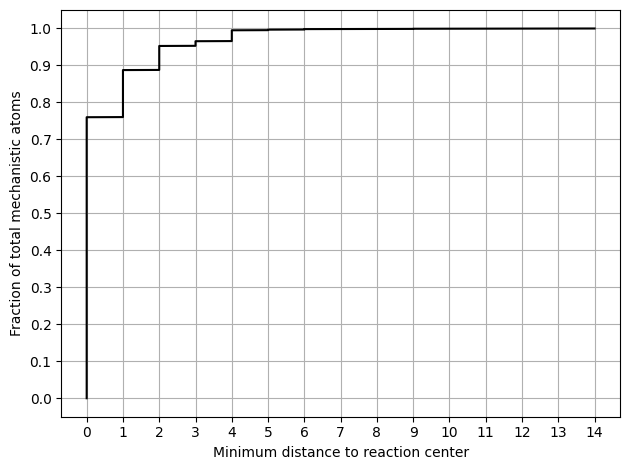

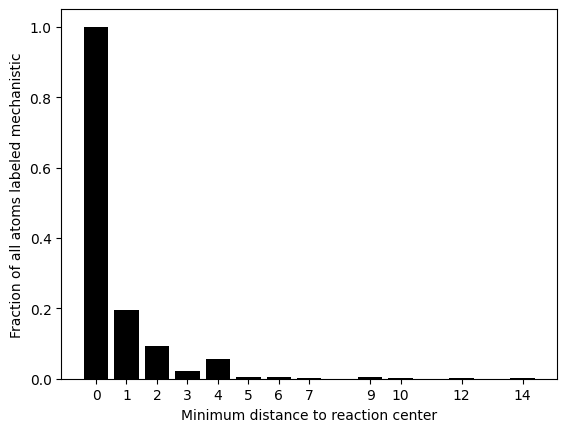

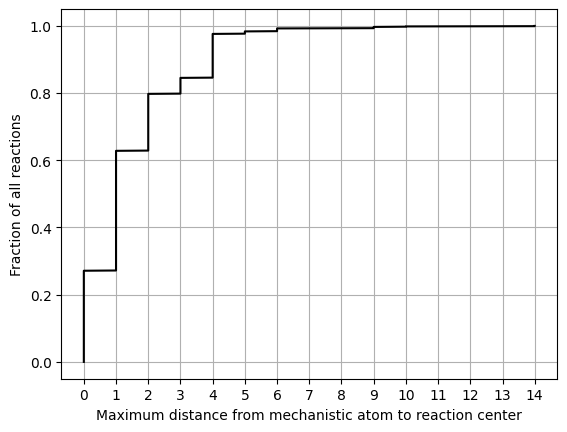

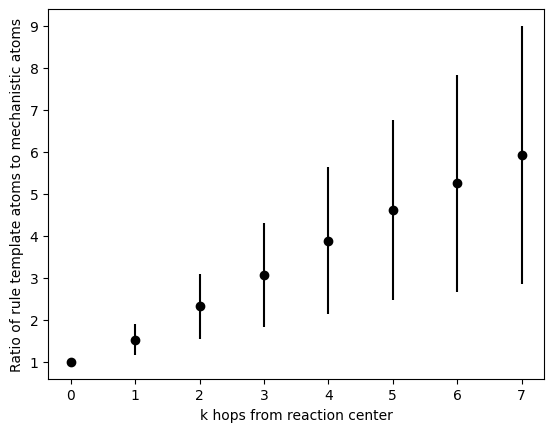

In [4]:
tmp = []
tot_by_radius = defaultdict(int)
mech_by_radius = defaultdict(int)
max_mech_dist = defaultdict(int)
rule_mech_ratios = defaultdict(list)
atom_cols = ["dist_to_rc", "mechanistic"]
atom_data = []
for i, row in mm.iterrows():
    smarts = row["smarts"]
    lhs_mols = [Chem.MolFromSmiles(elt) for elt in smarts.split('>>')[0].split('.')]
    lrc = row["reaction_center"][0]
    mech_atoms = row["mech_atoms"][0]
    tmp_rule = defaultdict(int)
    tmp_mech = defaultdict(int)
    for mol, rc, mech in zip(lhs_mols, lrc, mech_atoms):
        for atom in mol.GetAtoms():
            aidx = atom.GetIdx()
            min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)
            tot_by_radius[min_dist] += 1
            tmp_rule[min_dist] += 1

            if aidx in mech or min_dist == 0:
                mech_by_radius[min_dist] += 1
                tmp_mech[min_dist] += 1
                tmp.append((min_dist, row["entry_id"], row["mechanism_id"]))
                atom_data.append([min_dist, 1])
                
                if min_dist > max_mech_dist[i]:
                    max_mech_dist[i] = min_dist
            
            else:
                atom_data.append([min_dist, 0])
    
    for ub in tmp_rule.keys():
        mech_tot = sum(tmp_mech[k] for k in tmp_mech.keys())
        ratio = sum(tmp_rule[k] for k in tmp_rule.keys() if k <= ub) / mech_tot

        if ratio >= 1:
            rule_mech_ratios[ub].append(ratio)

df = pd.DataFrame(tmp, columns=["min_dist_to_rc", "entry_id", "mechanism_id"]).sort_values(by="min_dist_to_rc", ascending=False)
atom_df = pd.DataFrame(atom_data, columns=atom_cols)
frac_by_radius = {k: mech_by_radius[k] / tot_by_radius[k] for k in mech_by_radius.keys()}
min_dists_to_rc = sorted([x[0] for x in tmp])
rule_mech_ratios_mean_std = [(np.mean(rule_mech_ratios[k]), np.std(rule_mech_ratios[k])) for k in sorted(rule_mech_ratios.keys())]

fig, ax = plt.subplots()
ycdf = np.arange(len(min_dists_to_rc)) / len(min_dists_to_rc)
ax.plot(min_dists_to_rc, ycdf, color='black')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, max(min_dists_to_rc) + 1, 1))
ax.set_xlabel("Minimum distance to reaction center")
ax.set_ylabel("Fraction of total mechanistic atoms")
ax.grid()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
x = list(frac_by_radius.keys())
y = list(frac_by_radius.values())
ax.bar(x, y, color='black')
ax.set_xticks(x)
ax.set_xlabel("Minimum distance to reaction center")
ax.set_ylabel("Fraction of all atoms labeled mechanistic")
plt.show()

fig, ax = plt.subplots()
xcdf = sorted(max_mech_dist.values())
ycdf = np.arange(len(xcdf)) / len(xcdf)
ax.plot(xcdf, ycdf, color='black')
ax.set_xticks(np.arange(0, max(xcdf) + 1, 1))
ax.set_xlabel("Maximum distance from mechanistic atom to reaction center")
ax.set_ylabel("Fraction of all reactions")
ax.grid()
plt.show()

fig, ax = plt.subplots()
max_k = 8
x = sorted(rule_mech_ratios.keys())[:max_k]
y, yerr = zip(*rule_mech_ratios_mean_std[:max_k])
ax.errorbar(x, y, yerr=yerr, fmt='o', color='black')
ax.set_xticks(x)
ax.set_xlabel("k hops from reaction center")
ax.set_ylabel("Ratio of rule template atoms to mechanistic atoms")
plt.show()

R = 0: Accuracy = 0.957, Precision = 1.000, Recall = 0.760, F1 = 0.864
R = 1: Accuracy = 0.886, Precision = 0.626, Recall = 0.888, F1 = 0.734
R = 2: Accuracy = 0.785, Precision = 0.450, Recall = 0.953, F1 = 0.611
R = 3: Accuracy = 0.690, Precision = 0.360, Recall = 0.966, F1 = 0.525
R = 4: Accuracy = 0.607, Precision = 0.311, Recall = 0.995, F1 = 0.474


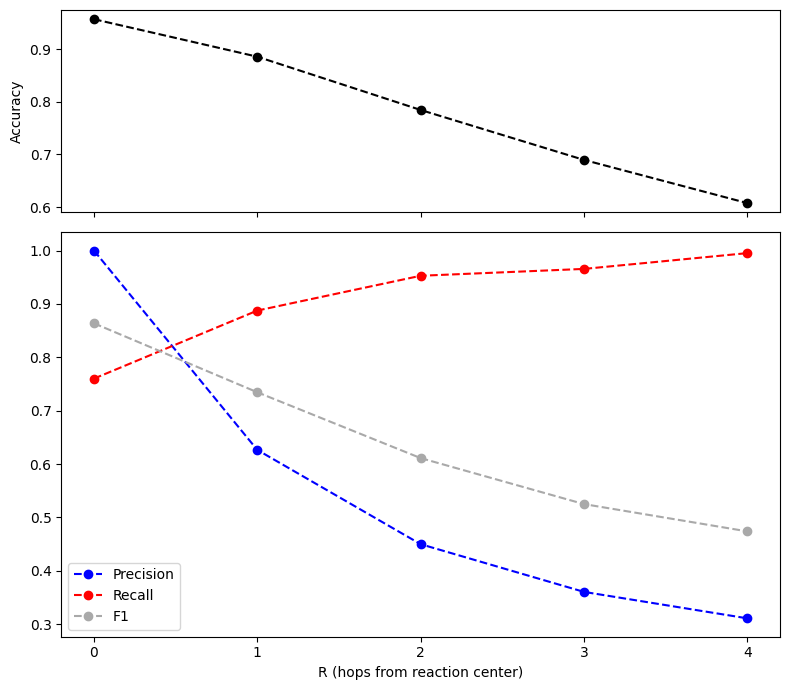

In [12]:
Rs = [0, 1, 2, 3, 4]
accs = []
precs = []
recs = []
f1s = []
for R in Rs:
    y_pred = (atom_df["dist_to_rc"] <= R).to_numpy(dtype=int)
    y_true = atom_df["mechanistic"].to_numpy(dtype=int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"R = {R}: Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, F1 = {f1:.3f}")
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
ax[0].plot(Rs, accs, marker='o', linestyle='--', color='black')
ax[0].set_xticks(Rs)
ax[0].set_ylabel("Accuracy")
ax[1].plot(Rs, precs, marker='o', linestyle='--', color='blue', label='Precision')
ax[1].set_xticks(Rs)
ax[1].set_xlabel("R (hops from reaction center)")
ax[1].plot(Rs, recs, marker='o', color='red', linestyle='--', label='Recall')
ax[1].plot(Rs, f1s, marker='o', color='darkgray', linestyle='--', label='F1')
ax[1].legend()
plt.tight_layout()
plt.show()

Extreme cases

In [6]:
max_min_dist = df.groupby(["entry_id", "mechanism_id"])["min_dist_to_rc"].max().reset_index()
max_min_dist = max_min_dist.sort_values(by="min_dist_to_rc", ascending=False).reset_index(drop=True)
print(len(max_min_dist))
max_min_dist.head(15)

673


,entry_id,mechanism_id,min_dist_to_rc
0,970,1,14
1,993,2,10
2,367,2,9
3,293,1,9
4,993,1,9
5,190,1,6
6,742,1,6
7,975,6,6
8,975,5,6
9,975,4,6


Showing example: 970, 1


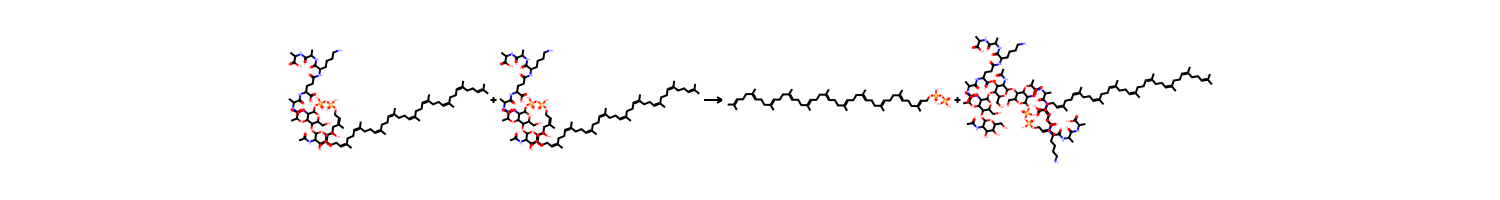

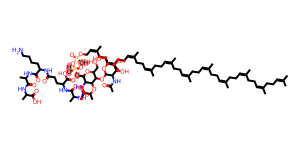

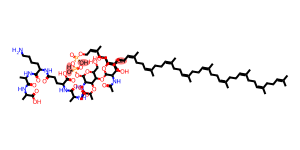

Showing example: 993, 2


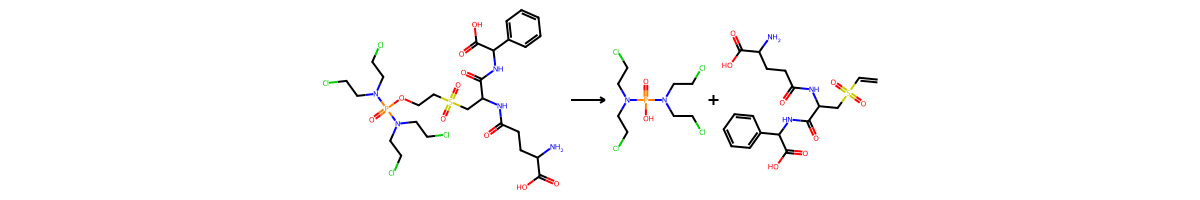

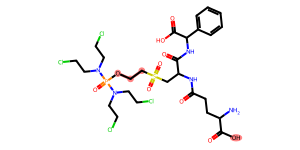

Showing example: 367, 2


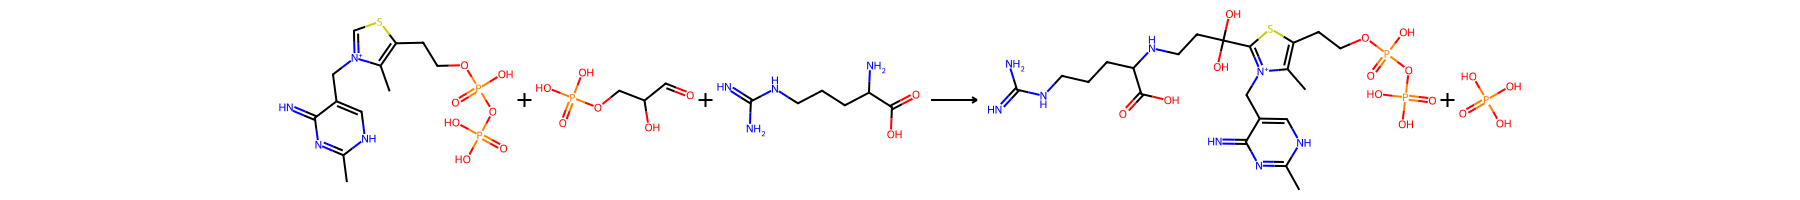

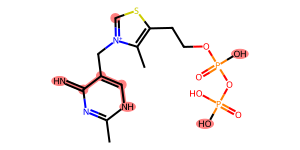

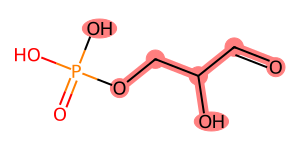

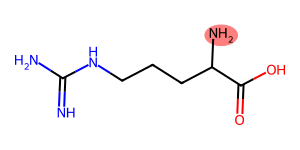

Showing example: 293, 1


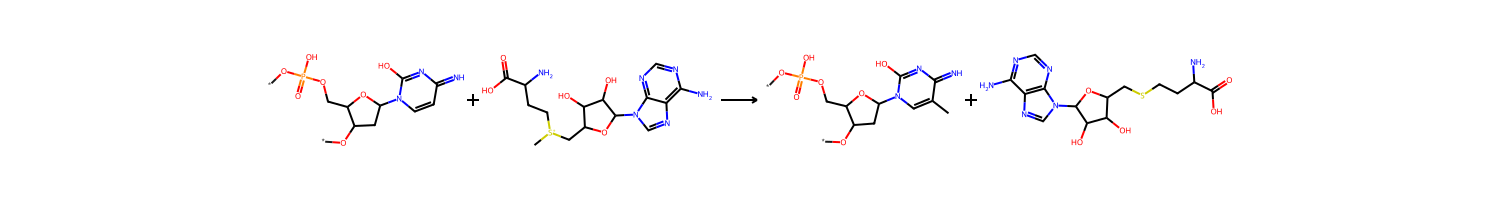

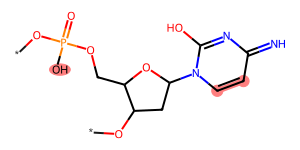

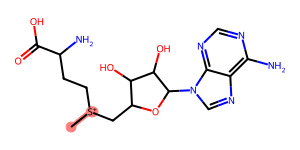

Showing example: 993, 1


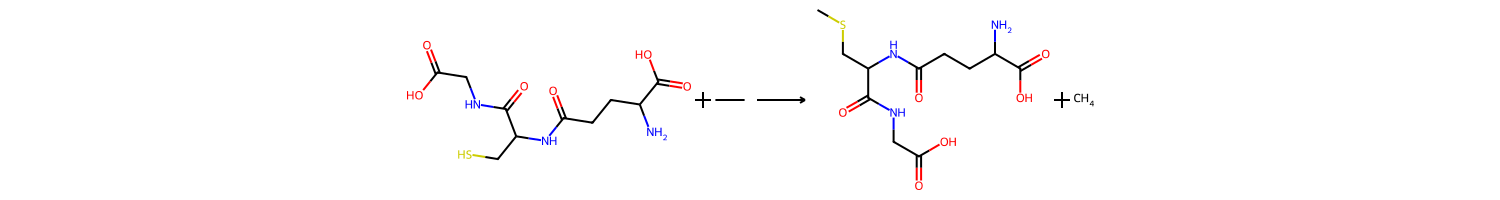

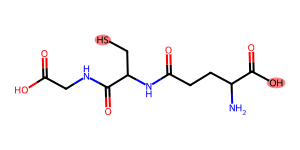

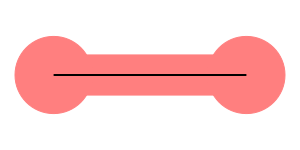

Showing example: 190, 1


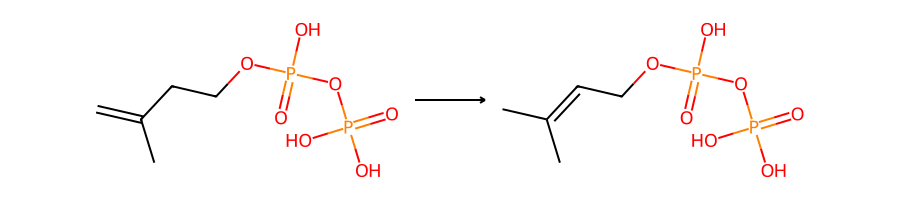

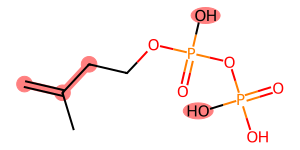

Showing example: 742, 1


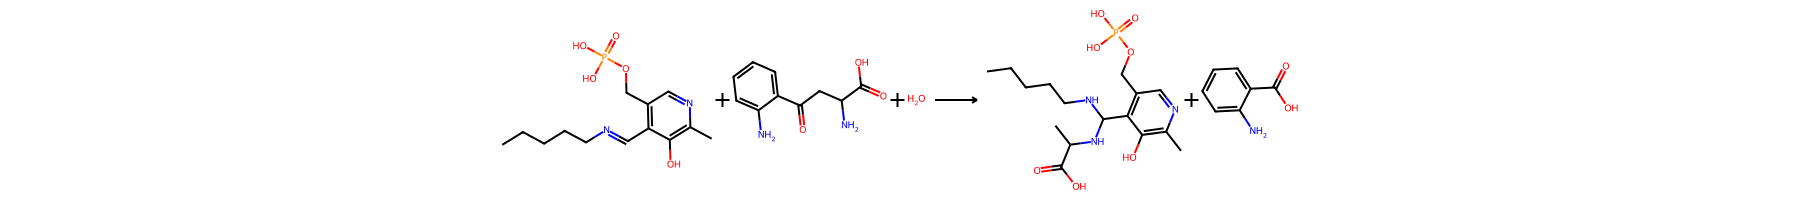

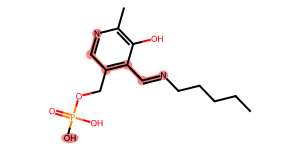

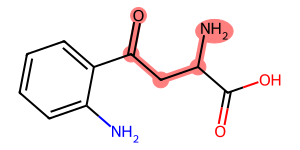

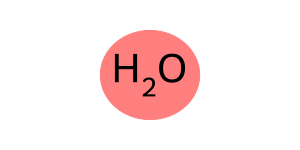

Showing example: 975, 6


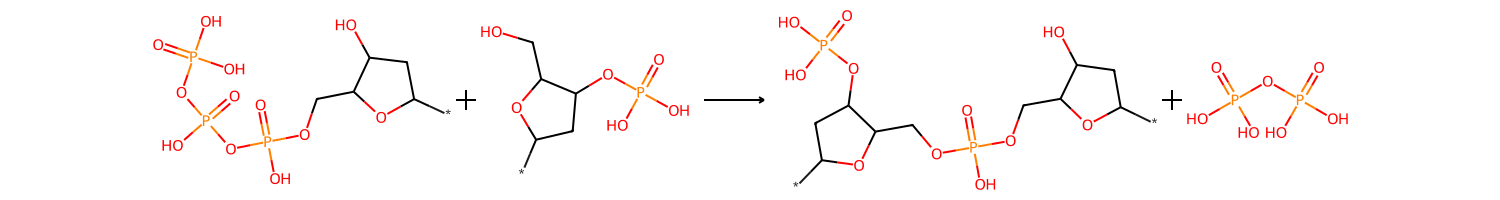

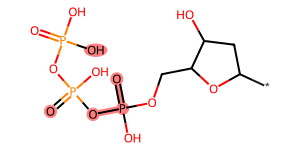

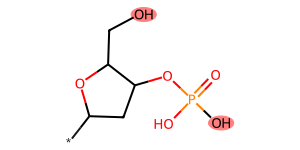

Showing example: 975, 5


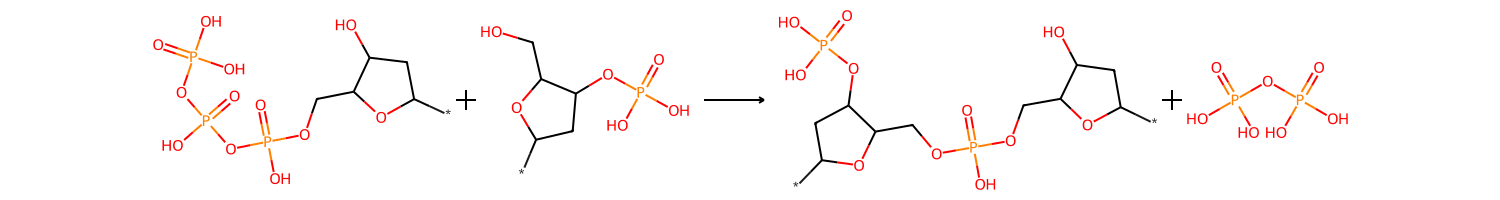

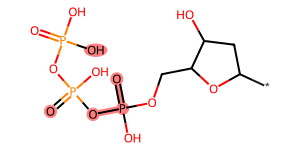

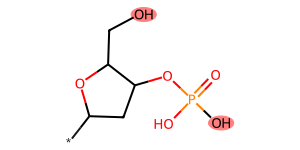

Showing example: 975, 4


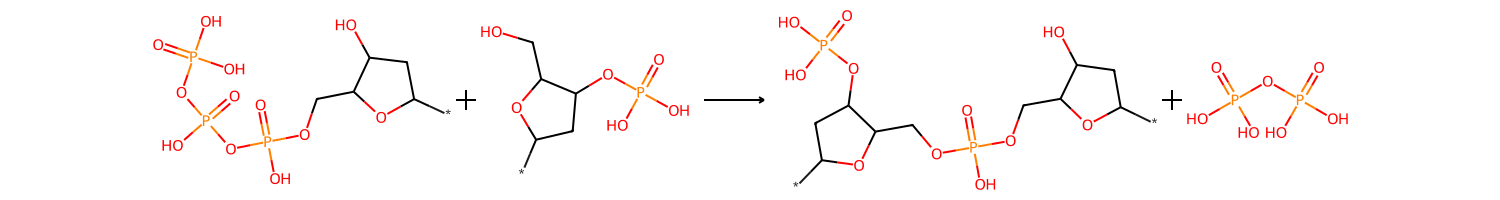

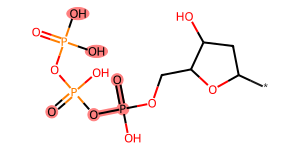

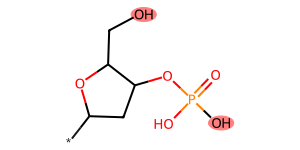

Showing example: 989, 3


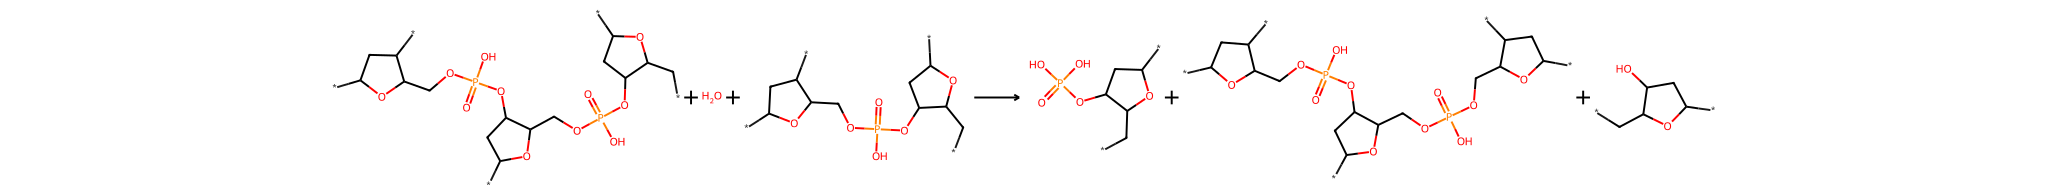

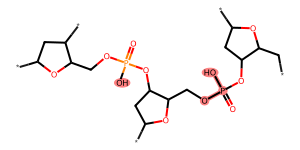

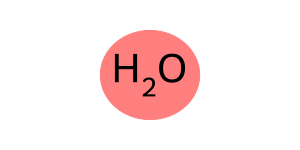

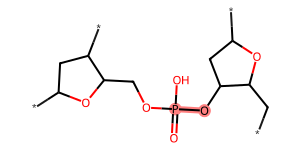

Showing example: 83, 1


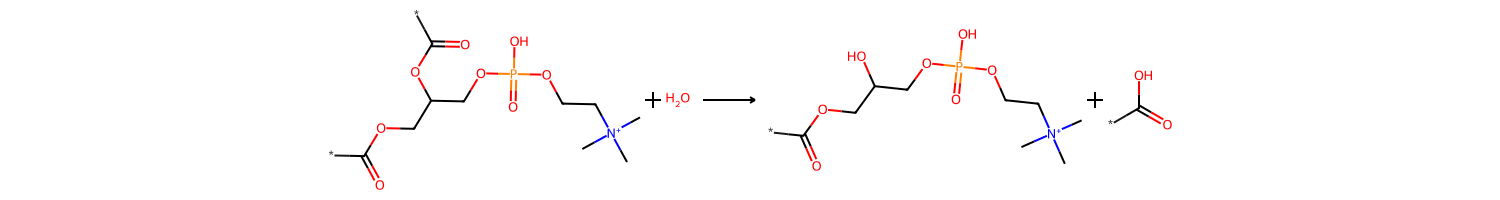

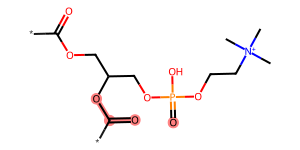

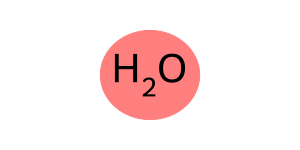

Showing example: 347, 1


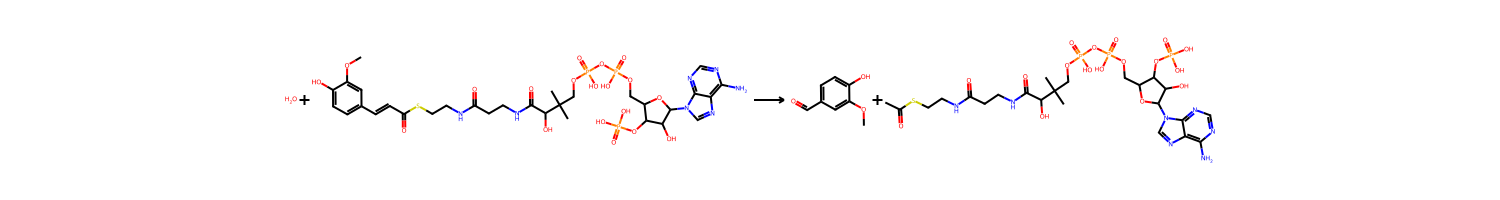

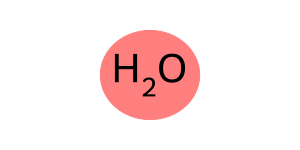

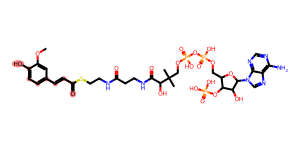

Showing example: 994, 1


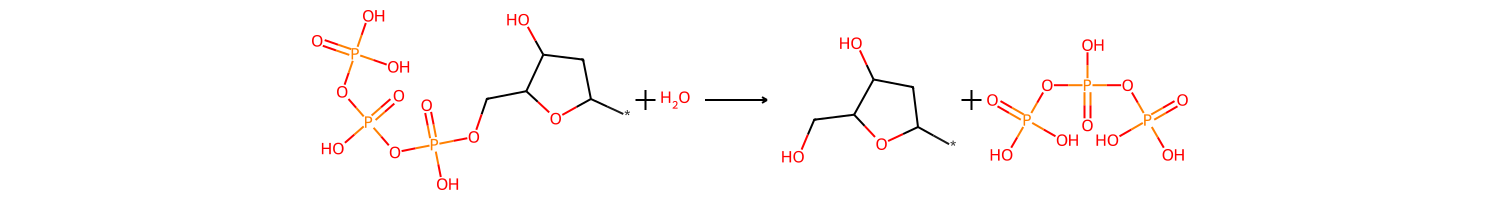

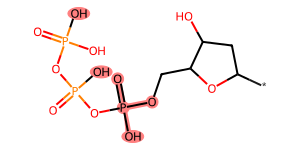

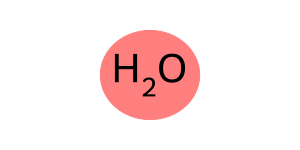

Showing example: 247, 1


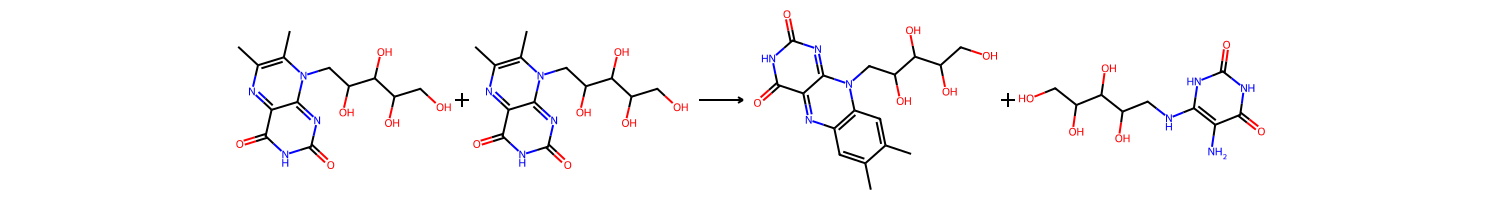

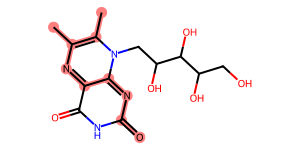

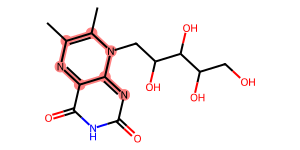

Showing example: 741, 1


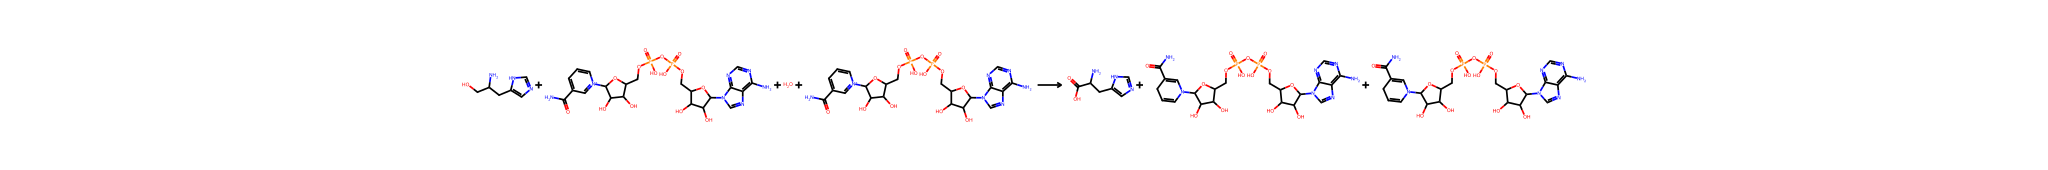

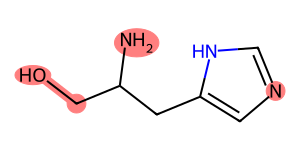

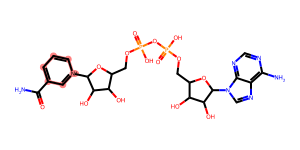

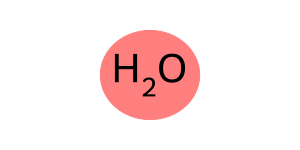

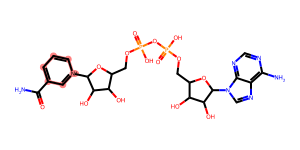

Showing example: 1000, 1


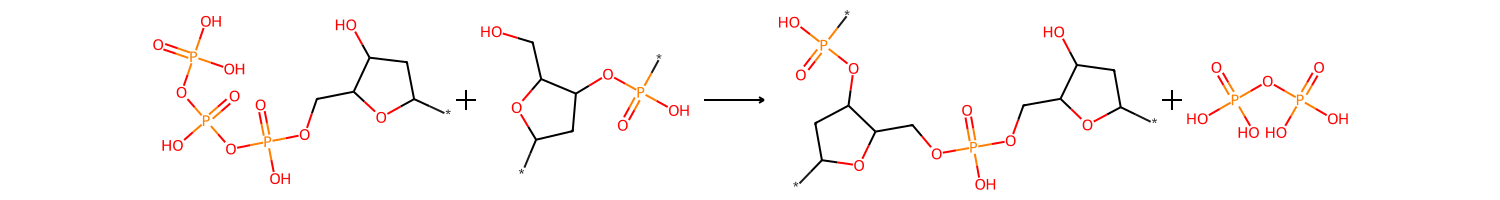

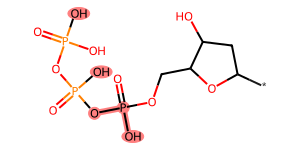

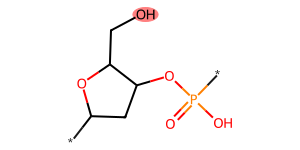

Showing example: 48, 1


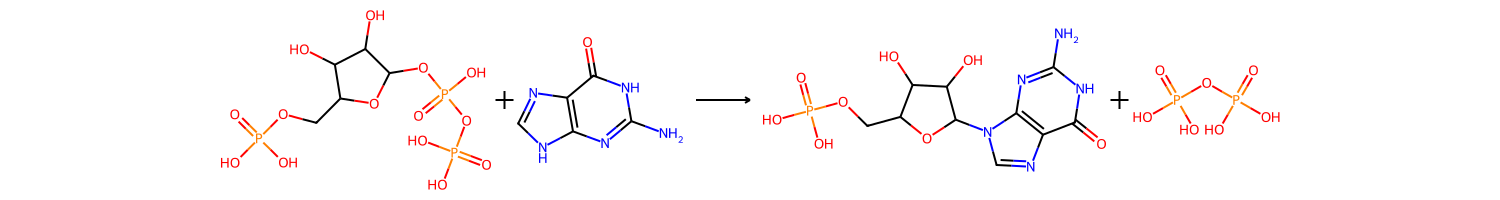

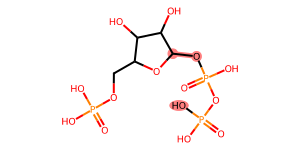

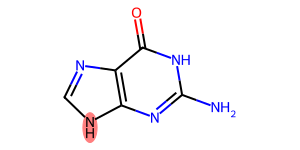

Showing example: 933, 1


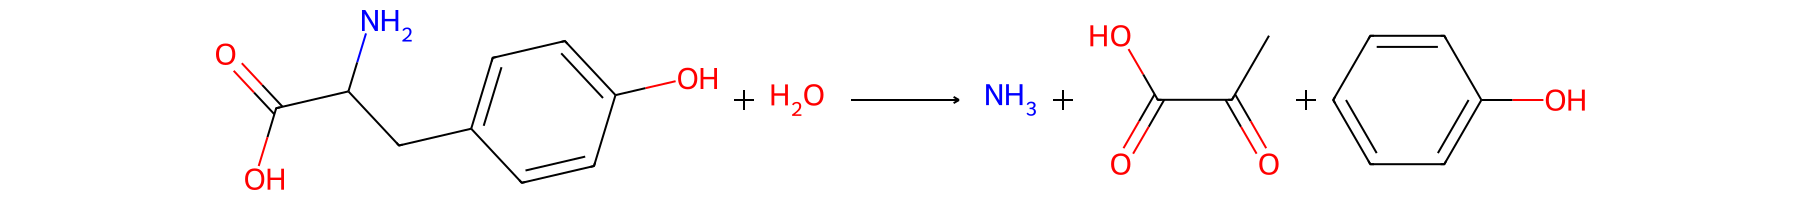

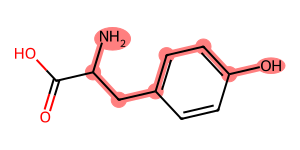

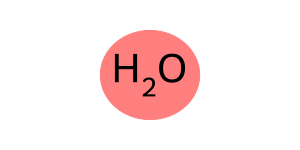

Showing example: 58, 1


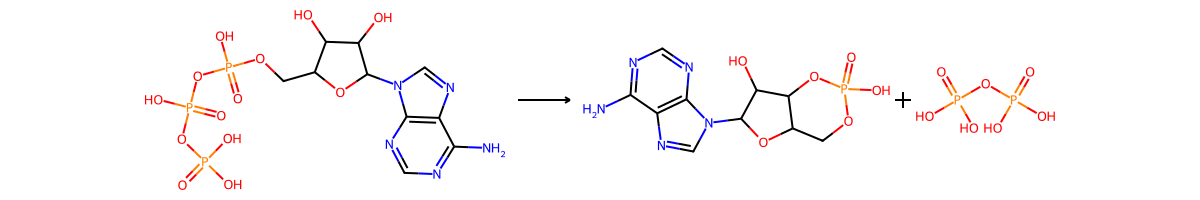

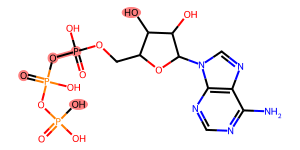

In [7]:
for i, row in max_min_dist.iloc[:20].iterrows():
    entry_id = row["entry_id"]
    mechanism_id = row["mechanism_id"]
    reaction_row = mm.loc[(mm["entry_id"] == entry_id) & (mm["mechanism_id"] == mechanism_id)].iloc[0]
    smarts = reaction_row["smarts"]
    reaction_center = reaction_row["reaction_center"]
    mech_atoms = reaction_row["mech_atoms"]
    rct = Chem.MolFromSmiles(smarts.split('>>')[0])
    print(f"Showing example: {entry_id}, {mechanism_id}")
    display(SVG(draw_reaction(smarts)))
    for smi, rc, ma in zip(smarts.split(">>")[0].split("."), reaction_center[0], mech_atoms[0]):
        hatoms = list(set(rc) | set(ma))
        display(SVG(draw_molecule(smi, size=(300, 150), highlight_atoms=hatoms)))